## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")



cuda is enabled!
cuda is enabled!


### 1. Generate data from Archimedean spiral

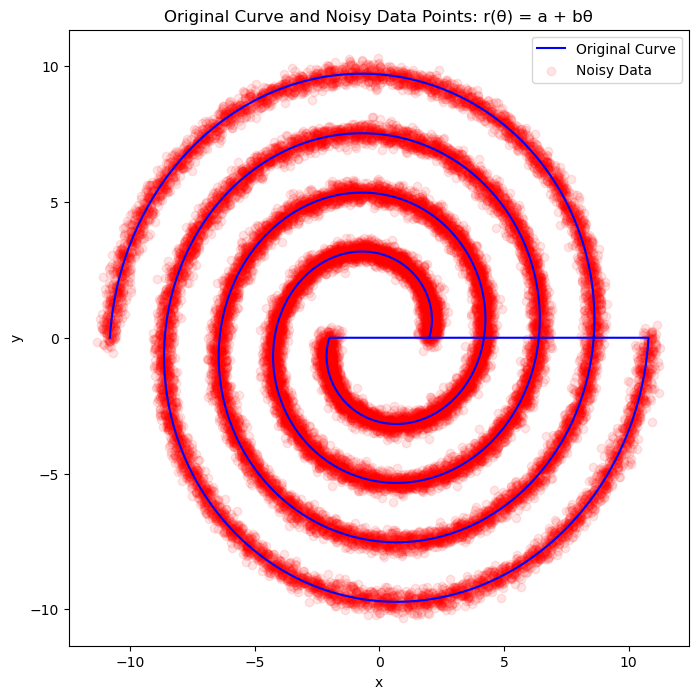

In [2]:
data = GenerateDataset()

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float,device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=700, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 3000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each row
    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/3000], Cost = 0.14553223550319672
Epoch [20/3000], Cost = 0.10737401992082596
Epoch [30/3000], Cost = 0.08296839147806168
Epoch [40/3000], Cost = 0.06783583760261536
Epoch [50/3000], Cost = 0.05825179070234299
Epoch [60/3000], Cost = 0.05229061841964722
Epoch [70/3000], Cost = 0.04853216931223869
Epoch [80/3000], Cost = 0.04609785974025726
Epoch [90/3000], Cost = 0.04451991617679596
Epoch [100/3000], Cost = 0.04345158860087395
Epoch [110/3000], Cost = 0.042595136910676956
Epoch [120/3000], Cost = 0.04194965586066246
Epoch [130/3000], Cost = 0.04151642695069313
Epoch [140/3000], Cost = 0.04122013971209526
Epoch [150/3000], Cost = 0.04100209102034569
Epoch [160/3000], Cost = 0.04082883149385452
Epoch [170/3000], Cost = 0.040681175887584686
Epoch [180/3000], Cost = 0.0405796617269516
Epoch [190/3000], Cost = 0.04048284515738487
Epoch [200/3000], Cost = 0.04036509990692139
Epoch [210/3000], Cost = 0.040266625583171844
Epoch [220/3000], Cost = 0.040176618844270706
Epoch [230/3000]

### Plot learnt dictionary and clustered data points

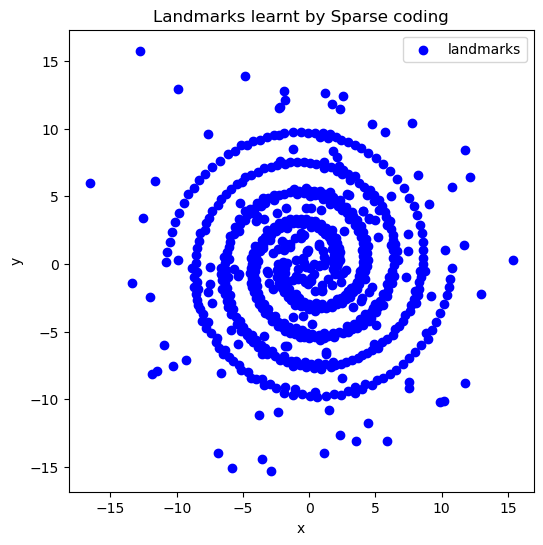

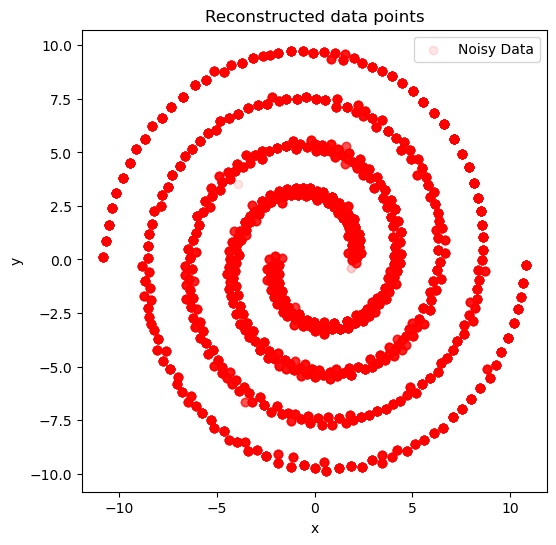

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


## 2. Assign similarity (Define D)

### 2.1 Try apply manifold learning on basis, not full data